<a href="https://colab.research.google.com/github/DanielaaVargas/NINE/blob/main/NGC5258.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages installation and import**


In [16]:
%%capture
!pip install astropy==5.3;
!pip install pyregion;
!pip install photutils;
!pip install regions;
!pip install scipy;
!pip install aplpy;

import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import pyregion
from astropy.coordinates import Angle
from astropy import units as u
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
from regions import Regions
from pyregion import get_mask
import aplpy
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

#**Galaxy NGC5258 Display using aplpy**

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
INFO:astropy:Auto-setting vmin to -9.820e-05
INFO:astropy:Auto-setting vmax to  4.820e-04


INFO: Auto-setting vmin to -9.820e-05 [aplpy.core]
INFO: Auto-setting vmax to  4.820e-04 [aplpy.core]


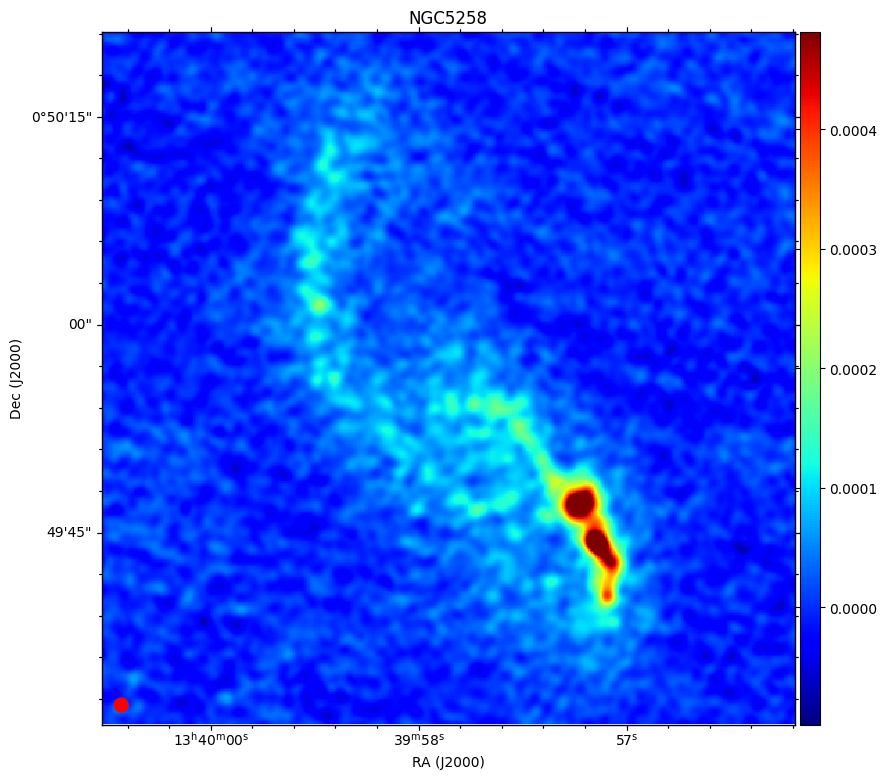

In [132]:
path = '/content/drive/MyDrive/NINE/Imaging/'

Image = path + 'NGC5258.fits'

iMg = aplpy.FITSFigure(Image)
iMg.set_title("NGC5258")
iMg.show_colorscale(cmap='jet')
iMg.add_colorbar()
#iMg.add_grid()
iMg.add_beam()
iMg.beam.set_color('red')

# **Header Data Unit (HDU)**

This shows the metadata and information about the fits file.

In [78]:
IMG = fits.open(Image)  #HDU List
PrimaryHDU = IMG[0]     #PrimaryHDU object

print(IMG)
print(IMG.info())
print(PrimaryHDU)

print('\nTotal intensity: ', PrimaryHDU.data.sum(), '\n')

PrimaryHDU.data

Filename: /content/drive/MyDrive/NINE/Imaging/NGC5258.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     464   (500, 500)   float32   
None

Total intensity:  3.587452 



array([[-8.42795816e-06, -3.88800254e-06,  8.59378986e-07, ...,
        -1.60543896e-05, -9.20454568e-06, -3.89002980e-06],
       [-6.05034165e-06, -1.99048918e-06,  2.53755479e-06, ...,
        -1.41792461e-05, -7.44180943e-06, -1.89061109e-06],
       [-4.39967926e-06, -6.59264344e-07,  3.81479958e-06, ...,
        -1.35508508e-05, -7.15010765e-06, -1.43404975e-06],
       ...,
       [ 3.28053102e-06,  8.53455276e-06,  1.23046302e-05, ...,
        -1.65220354e-05, -1.59263218e-05, -1.60143027e-05],
       [-4.76962805e-06, -1.61062246e-07,  3.38781524e-06, ...,
        -1.56560654e-05, -1.48928502e-05, -1.47071187e-05],
       [-1.40863476e-05, -1.02853055e-05, -6.93907532e-06, ...,
        -1.26009099e-05, -1.17542404e-05, -1.14344302e-05]], dtype='>f4')

In [80]:
header = PrimaryHDU.header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  500                                                  
BMAJ    =   2.777777777778E-04                                                  
BMIN    =   2.777777777778E-04                                                  
BPA     =   0.000000000000E+00                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'NGC 5257/8'                                                          
BUNIT   = 'Jy/beam '           /Brightness (pixel) unit                         
EQUINOX =   2.000000000000E+03                                                  
RADESYS = 'FK5     '        

# **Noise Characterization**

It is possible to calculate the average noise of a fits file.

In [172]:
Regions = path + 'DS9.reg'
vla = fits.getdata(Image)
data = PrimaryHDU.data
print(vla.shape, '\n')

reg = pyregion.open(Regions)
reg

(500, 500) 



[Shape : circle ( Number(53),Number(419),Number(20) ),
 Shape : circle ( Number(393),Number(449),Number(19.932905) ),
 Shape : circle ( Number(441),Number(320),Number(27.573967) ),
 Shape : circle ( Number(38.456),Number(60.92),Number(24.447757) ),
 Shape : circle ( Number(145.592),Number(54.008),Number(23.584063) ),
 Shape : circle ( Number(453.176),Number(107.576),Number(14.395013) ),
 Shape : circle ( Number(73.016),Number(192.248),Number(53.362276) ),
 Shape : circle ( Number(373.688),Number(352.952),Number(39.456229) )]

In [173]:
rms_values = []
for n in range(len(reg)):
  reg = pyregion.open(Regions)
  m=len(reg)
  del reg[0:n]  #deletes only the first element of the list in each loop
  del reg[1:m]  #leaves only the first element of the list in each loop
  mask = reg.get_mask(shape = vla.shape, header = header)
  mask = get_mask(reg, data)
  maskdata = np.multiply(vla, mask)
  N = len(maskdata[maskdata!=0])
  rms_values.append(np.sqrt(np.sum(maskdata**2)/N))
avg_rms = np.mean(rms_values)
avg_rms  #Average noise

1.8055913129607442e-05

In [192]:
maskdata[maskdata!=0]
mask[1][mask[1]==True]
maskdata

array([[7.1030480e-11, 1.5116564e-11, 7.3853223e-13, ..., 2.5774344e-10,
        8.4723659e-11, 1.5132331e-11],
       [3.6606634e-11, 3.9620473e-12, 6.4391843e-12, ..., 2.0105102e-10,
        5.5380527e-11, 3.5744103e-12],
       [1.9357177e-11, 4.3462946e-13, 1.4552696e-11, ..., 1.8362556e-10,
        5.1124039e-11, 2.0564986e-12],
       ...,
       [1.0761884e-11, 7.2838589e-11, 1.5140393e-10, ..., 2.7297764e-10,
        2.5364771e-10, 2.5645788e-10],
       [2.2749351e-11, 2.5941046e-14, 1.1477292e-11, ..., 2.4511237e-10,
        2.2179698e-10, 2.1629934e-10],
       [1.9842519e-10, 1.0578751e-10, 4.8150765e-11, ..., 1.5878293e-10,
        1.3816216e-10, 1.3074619e-10]], dtype=float32)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.



How many contours do you want to do? 3

	CONTOUR 1
How many average rms above? 3

Color pink



	CONTOUR 2
How many average rms above? 5

Color green



	CONTOUR 3
How many average rms above? 7

Color white


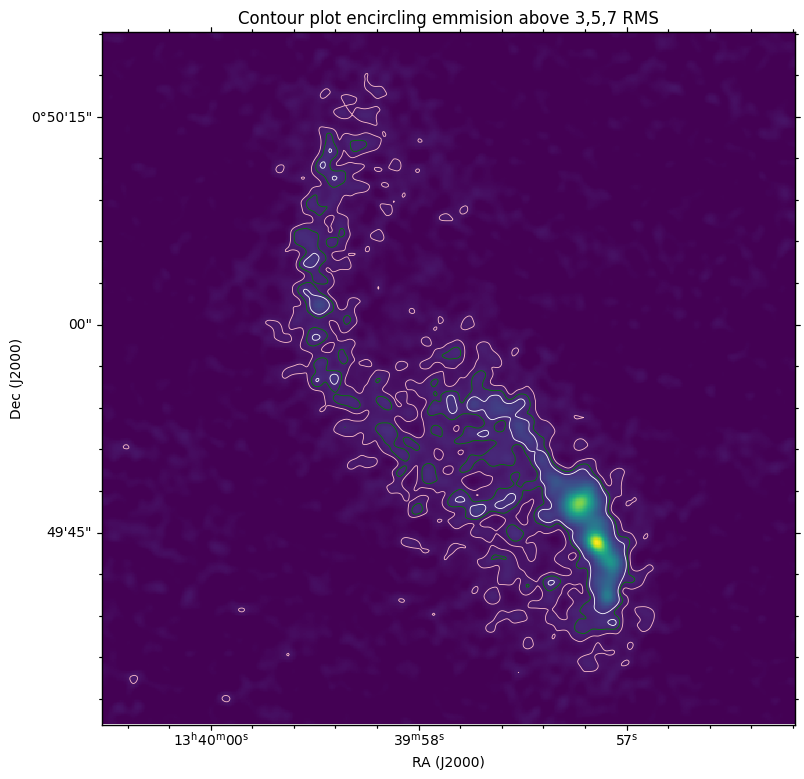

In [222]:
fig = aplpy.FITSFigure(Image)
fig.show_colorscale(vmin=0, vmax=np.max(vla), stretch='linear')

contours = int(input('\nHow many contours do you want to do? '))
rms = []
for n in range(contours):
  n = int(input(f'\n\tCONTOUR {n+1}\nHow many average rms above? '))
  color = input('\nColor ')
  fig.show_contour(data=vla, levels=[n*avg_rms], colors=[color], linewidths=0.6)
  rms.append(n)

rms_string = ','.join(map(str, rms))
fig.set_title(f'Contour plot encircling emmision above {rms_string} RMS')